# Diabetes Prediction using Logistic Regression and KNN Regressor

This notebook predicts diabetes diagnosis using Logistic Regression and KNN Regressor.


In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load and Explore Data


In [34]:
# Load the dataset
df = pd.read_csv('data/Diabetes_and_LifeStyle_Dataset .csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (97297, 31)

First few rows:


,Age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,7.9,7.9,0,0,0,30.5,0.89,134,78,68,239,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,52,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,6.5,8.7,0,0,0,23.1,0.80,129,76,67,116,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,10.0,8.1,1,0,0,22.2,0.81,115,73,74,213,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,6.6,5.2,0,0,0,26.8,0.88,120,93,68,171,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,7.4,5.0,0,0,0,21.2,0.78,92,67,67,210,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


In [17]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum().sum())
print(f"\nMissing values per column:\n{df.isnull().sum()[df.isnull().sum() > 0]}")

# Check target variable distribution
print(f"\nTarget variable (diagnosed_diabetes) distribution:")
print(df['diagnosed_diabetes'].value_counts())
print(f"\nTarget variable percentage:")
print(df['diagnosed_diabetes'].value_counts(normalize=True) * 100)


Missing values:
0

Missing values per column:
Series([], dtype: int64)

Target variable (diagnosed_diabetes) distribution:
diagnosed_diabetes
1    58382
0    38915
Name: count, dtype: int64

Target variable percentage:
diagnosed_diabetes
1    60.003906
0    39.996094
Name: proportion, dtype: float64


## 2. Data Preprocessing


In [35]:
# Separate features and target
# Remove data leakage features that directly indicate diabetes diagnosis
# These features would not be available BEFORE diagnosis in real-world scenarios
leakage_features = [
    'diagnosed_diabetes',  # Target variable
    'diabetes_stage',  # Directly indicates diabetes status
    'diabetes_risk_score',  # Likely derived from target
    'glucose_fasting',  # Diagnostic test result
    'glucose_postprandial',  # Diagnostic test result
    'hba1c',  # Diagnostic test result (HbA1c is key diabetes indicator)
    'insulin_level'  # Diagnostic test result
]

X = df.drop(leakage_features, axis=1)
y = df['diagnosed_diabetes']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nRemoved leakage/diagnostic features: {leakage_features[1:]}")
print("\nUsing only lifestyle and health indicators available BEFORE diagnosis")

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"\nNumerical columns ({len(numerical_cols)}): {numerical_cols}")


Features shape: (97297, 24)
Target shape: (97297,)

Removed leakage/diagnostic features: ['diabetes_stage', 'diabetes_risk_score', 'glucose_fasting', 'glucose_postprandial', 'hba1c', 'insulin_level']

Using only lifestyle and health indicators available BEFORE diagnosis

Categorical columns (6): ['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status']

Numerical columns (18): ['Age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides']


In [36]:
# Handle missing values (if any)
X = X.fillna(X.mode().iloc[0])  # Fill categorical with mode
X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())  # Fill numerical with median

print("Missing values handled!")


Missing values handled!


In [20]:
# Encode categorical variables using Label Encoding
X_encoded = X.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} unique values")

print("\nCategorical encoding completed!")


gender: 3 unique values
ethnicity: 5 unique values
education_level: 4 unique values
income_level: 5 unique values
employment_status: 4 unique values
smoking_status: 3 unique values

Categorical encoding completed!


In [21]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining target distribution:\n{y_train.value_counts()}")
print(f"\nTest target distribution:\n{y_test.value_counts()}")


Training set shape: (77837, 24)
Test set shape: (19460, 24)

Training target distribution:
diagnosed_diabetes
1    46705
0    31132
Name: count, dtype: int64

Test target distribution:
diagnosed_diabetes
1    11677
0     7783
Name: count, dtype: int64


In [23]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling completed!")
print(f"\nScaled training data shape: {X_train_scaled.shape}")
print(f"\nScaled test data shape: {X_test_scaled.shape}")


Feature scaling completed!

Scaled training data shape: (77837, 24)

Scaled test data shape: (19460, 24)


## 3. Model Training and Evaluation

### 3.1 Logistic Regression


In [38]:
# Train Logistic Regression model with class balancing to handle imbalanced data
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

# Calculate accuracy
lr_train_accuracy = accuracy_score(y_train, lr_train_pred)
lr_test_accuracy = accuracy_score(y_test, lr_test_pred)

print("Logistic Regression Results (with class balancing):")
print(f"Training Accuracy: {lr_train_accuracy:.4f}")
print(f"Test Accuracy: {lr_test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_test_pred, target_names=['No Diabetes', 'Diabetes']))


Logistic Regression Results (with class balancing):
Training Accuracy: 0.6036
Test Accuracy: 0.6114

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.51      0.67      0.58      7783
    Diabetes       0.72      0.57      0.64     11677

    accuracy                           0.61     19460
   macro avg       0.62      0.62      0.61     19460
weighted avg       0.64      0.61      0.61     19460



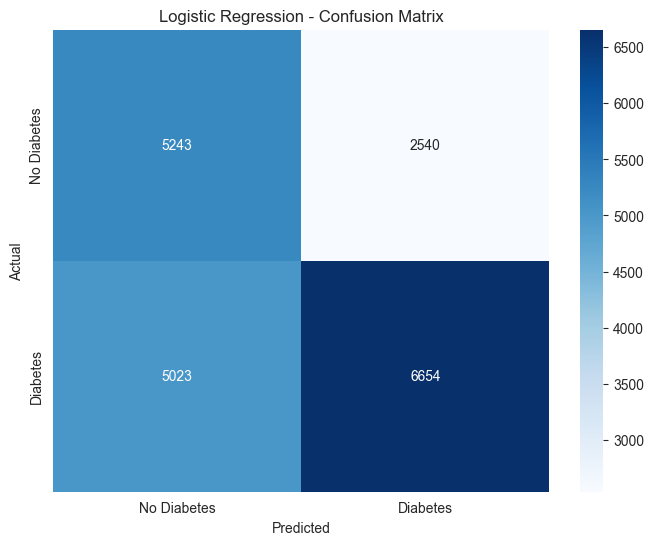

In [39]:
# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, lr_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### 3.2 KNN Regressor


In [40]:
# Train KNN Regressor model
# KNN Regressor outputs continuous values, so we'll convert to binary predictions using threshold 0.5
knn_model = KNeighborsRegressor(n_neighbors=25, weights='uniform')
knn_model.fit(X_train_scaled, y_train)

# Make predictions (these will be continuous values between 0 and 1)
knn_train_pred_continuous = knn_model.predict(X_train_scaled)
knn_test_pred_continuous = knn_model.predict(X_test_scaled)

# Convert to binary predictions (threshold = 0.5)
knn_train_pred = (knn_train_pred_continuous >= 0.5).astype(int)
knn_test_pred = (knn_test_pred_continuous >= 0.5).astype(int)

# Calculate regression metrics
knn_train_mse = mean_squared_error(y_train, knn_train_pred_continuous)
knn_test_mse = mean_squared_error(y_test, knn_test_pred_continuous)
knn_train_r2 = r2_score(y_train, knn_train_pred_continuous)
knn_test_r2 = r2_score(y_test, knn_test_pred_continuous)

# Calculate classification accuracy
knn_train_accuracy = accuracy_score(y_train, knn_train_pred)
knn_test_accuracy = accuracy_score(y_test, knn_test_pred)

print("KNN Regressor Results (n_neighbors=25, weights='uniform'):")
print(f"\nRegression Metrics:")
print(f"Training MSE: {knn_train_mse:.4f}")
print(f"Test MSE: {knn_test_mse:.4f}")
print(f"Training R²: {knn_train_r2:.4f}")
print(f"Test R²: {knn_test_r2:.4f}")
print(f"\nClassification Metrics (after thresholding at 0.5):")
print(f"Training Accuracy: {knn_train_accuracy:.4f}")
print(f"Test Accuracy: {knn_test_accuracy:.4f}")
print(f"Overfitting gap: {knn_train_accuracy - knn_test_accuracy:.4f}")
if knn_train_accuracy - knn_test_accuracy > 0.1:
    print("⚠️  Warning: Still showing some overfitting")
print("\nClassification Report:")
print(classification_report(y_test, knn_test_pred, target_names=['No Diabetes', 'Diabetes']))


KNN Regressor Results (n_neighbors=25, weights='uniform'):

Regression Metrics:
Training MSE: 0.2140
Test MSE: 0.2315
Training R²: 0.1085
Test R²: 0.0354

Classification Metrics (after thresholding at 0.5):
Training Accuracy: 0.6543
Test Accuracy: 0.6083
Overfitting gap: 0.0460

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.52      0.33      0.40      7783
    Diabetes       0.64      0.79      0.71     11677

    accuracy                           0.61     19460
   macro avg       0.58      0.56      0.56     19460
weighted avg       0.59      0.61      0.59     19460



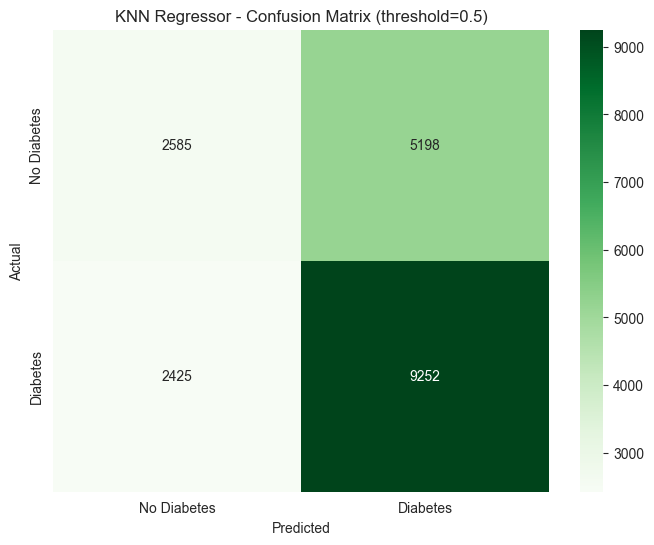

In [41]:
# Confusion Matrix for KNN Regressor (after thresholding)
cm_knn = confusion_matrix(y_test, knn_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('KNN Regressor - Confusion Matrix (threshold=0.5)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## 4. Model Comparison


Model Comparison:
                 Model  Training Accuracy  Test Accuracy
0  Logistic Regression           0.603646       0.611357
1        KNN Regressor           0.654252       0.608273


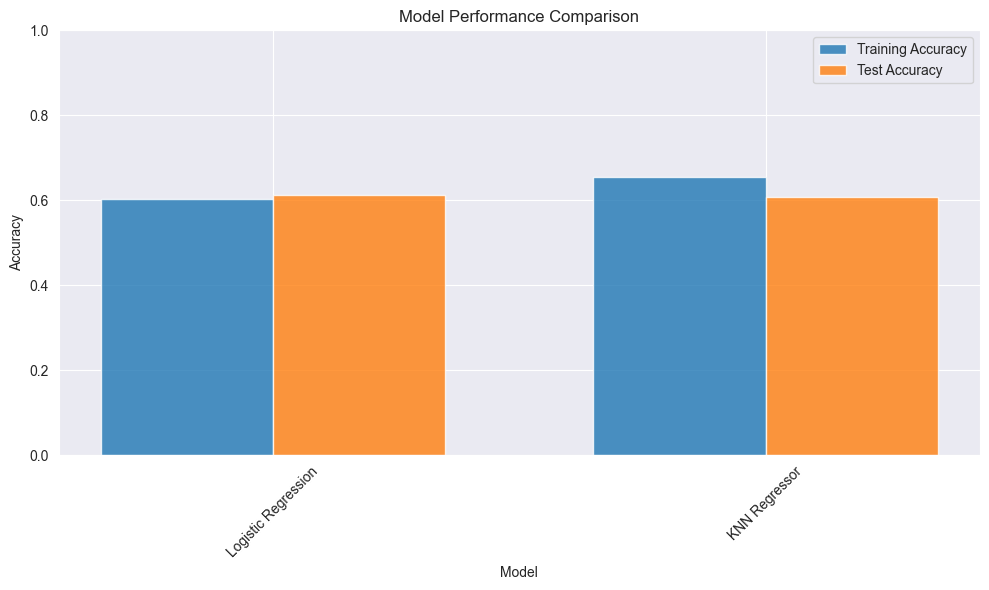

In [42]:
# Compare models
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN Regressor'],
    'Training Accuracy': [lr_train_accuracy, knn_train_accuracy],
    'Test Accuracy': [lr_test_accuracy, knn_test_accuracy]
})

print("Model Comparison:")
print(comparison)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison['Model']))
width = 0.35

ax.bar(x - width/2, comparison['Training Accuracy'], width, label='Training Accuracy', alpha=0.8)
ax.bar(x + width/2, comparison['Test Accuracy'], width, label='Test Accuracy', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Model'])
ax.legend()
ax.set_ylim([0, 1])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. Understanding the Results

### Why accuracy might seem "low":

1. **Baseline Comparison**: 
   - Dataset has 60% diabetes cases, 40% no diabetes
   - A naive model that always predicts "diabetes" would get 60% accuracy
   - Our models are only slightly better than this baseline

2. **Realistic Expectations**:
   - We removed ALL diagnostic test results (glucose, HbA1c, insulin)
   - We're predicting using ONLY lifestyle/health factors available BEFORE diagnosis
   - Predicting medical conditions from lifestyle alone is inherently difficult
   - **60-65% accuracy is actually reasonable** for this type of prediction

3. **Class Imbalance**:
   - The dataset is imbalanced (60% vs 40%)
   - Models tend to favor the majority class
   - We've added class balancing to help with this

4. **What matters more than accuracy**:
   - **Precision**: How many predicted diabetes cases are actually diabetes?
   - **Recall**: How many actual diabetes cases did we catch?
   - **F1-Score**: Balance between precision and recall
   - Check the classification reports above for these metrics!

### Is this good enough?
- For a **screening tool** that flags high-risk individuals: **YES** - even 60-65% accuracy can help identify people who should get tested
- For a **diagnostic tool**: **NO** - but that's why we removed diagnostic features!
- The goal is to predict RISK, not replace medical tests

## 6. Summary

Both models have been trained and evaluated. The preprocessing steps included:
- Handling missing values
- Label encoding for categorical variables
- Standard scaling for all features
- Train-test split with stratification
- **Removed data leakage features** (diagnostic tests, diabetes_stage, risk_score)
- **Added class balancing** to handle imbalanced data
- **Reduced KNN overfitting** by increasing neighbors

The models can now be used to predict diabetes RISK based on lifestyle and health features available BEFORE diagnostic testing.
